In [1]:
import numpy as np
import random
import copy
from random import randrange
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from numba import jit
#from copy import deepcopy

In [2]:
@jit(nopython= True)
def energy_grif (leng, sigma):
    return  - np.divide ( np.power(leng,3) * np.power(sigma,2), 24) +   leng

#    return leng * 3.7/6

In [3]:
ccrit = np.sqrt(8)/0.5
Ecrit = energy_grif(ccrit, 0.5)

In [4]:
@jit(nopython= True)
def energy_ising (leng, sigma):
#    return - np.divide ( np.power(leng,3) * np.power(sigma,2), 24) +   leng
    return leng * Ecrit/6


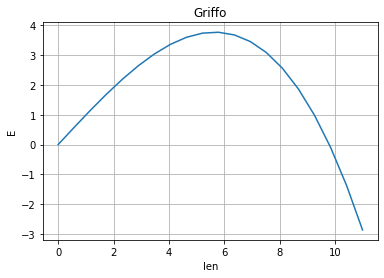

In [5]:
x = np.linspace(0,11,20)
y = energy_grif(x,0.5)
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='len', ylabel='E',
       title='Griffo')
ax.grid()

plt.show()

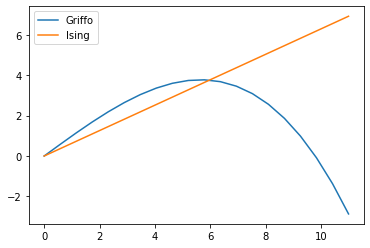

In [6]:
x = np.linspace(0,11,20)
y1 = energy_grif(x,0.5)
y2 = energy_ising(x,0.5)
plt.plot(x, y1,label='Griffo')
plt.plot(x, y2, label='Ising')
plt.legend()

In [7]:
@jit(nopython= True)
def start_config(size,  sigma, T, energy_func):
    prob = np.exp(-energy_func(1,sigma)/T)
    con = np.zeros(size)
    rand_unif = np.random.uniform(0,1,size)
    for i in range(size):
        if rand_unif[i] < prob:
            con[i] = 1
        else:
            con[i] = 0
    return con

In [8]:
@jit(nopython= True)
def energy_config(vect,sigma):
 griffo = 1
 ene = np.zeros(len(vect))
 for i in range (1,len(vect)):
  ene[i-1] = vect[i-1] * (griffo*(i) - sigma**2*(i/2)**3/3 )
 energy = np.sum(ene)
 return energy

In [9]:
@jit(nopython= True)
def countRightCirc(x,i,size):
    z = 1
    while (x[(i+z)%size]==1):
        z = z + 1
    return z

In [10]:
@jit(nopython= True)
def countLeftCirc(x,i,size):
    z = 1
    while (x[(i-z)%size]==1):
        z = z + 1
    return z

In [11]:
@jit(nopython= True)
def rollstart(b):
    return np.where(b==0)
        

In [12]:
@jit(nopython= True)
def config_count(b):
    c = np.roll(b,-np.where(b==0)[0][0])
    leng = 0
    res = np.zeros(len(b))
    for i in range(1,len(b)): 
        if (c[i]==0 and c[i-1]==1):
            res[leng-1] = res[leng-1]+1
            leng=0
        if (c[i]==1):
            leng = leng+1
    if c[len(b)-1]==1:
        res[leng-1]=res[leng-1]+1
    return res

In [13]:
@jit(nopython= True)
def maxCrackLen (b):
    return 1 + np.argmax ( np.multiply (np.arange(b.size), config_count(b) ) )

In [14]:
@jit(nopython= True)
def newEnergy(vect,sigma, i, flag, energy_func):
    siz = vect.size
    randelem = i
    cR = countRightCirc(vect,randelem, siz)-1
    cL = countLeftCirc(vect,randelem, siz)-1
    deltaEnergy = - energy_func(cR, sigma) - energy_func(cL, sigma) + energy_func(cR + cL +1, sigma)
    if vect[randelem]==1:
        deltaEnergy = - deltaEnergy
    else:
  #          crackmax = max(crackmax, cR + cL +1)
        if cR + cL + 1 >= 6:
           flag = 1
    return deltaEnergy, flag

In [15]:
@jit(nopython= True)
def swap (b,i):
    aux = np.copy(b)
    if aux[i] ==1:
     aux[i] = 0
    else:
     aux[i]=1
    return aux



In [16]:
@jit(nopython= True)
def mainIter(config, size, sigma, T, flag, energy_func):
    randelem = randrange(1,size)
    aux1 = newEnergy(config, sigma, randelem, flag, energy_func)
    deltaEne = aux1[0]
    alfa = np.amin(np.array([1, np.exp(-(1/T)*(deltaEne) )] ))
    beta = random.uniform(0,1)
    if beta < alfa:
#            en_old = en_new
            config = swap(config,randelem)
            flag = aux1[1]
    else:
        deltaEne = 0
    return config, deltaEne, flag
    

In [17]:
@jit
def tempvec(temp,realis):
    tot = realis * temp.size
    tempvec  = np.zeros(tot)
    for i in range(tot):
        tempvec[i] = temp[i//realis] 
    return tempvec
@jit 
def start_config_vec(temp,realis,siz, sigma, energy_func):
    tot = realis * temp.size
    startConfigVec  = np.zeros((tot,siz))
    for i in range(tot):
        startConfigVec[i,:] = start_config(siz, sigma, tempvec(temp,realis)[i], energy_func)
    return startConfigVec

In [18]:
@jit(nopython= True, parallel = False)
def MainVecto(sigma, tempe,size, realis, energy_func):
    tot = realis * tempe.size
    time = 0
    #ene = np.zeros(tot)
    flag = np.zeros(tot)
#    crack_old  = np.zeros(tot)
    metatime = np.zeros(tot)
    conf_init = start_config_vec(tempe, realis, size, sigma, energy_func)
    conf_old = np.copy(conf_init)
#   en_old = np.zeros(tot)
    metaconf = np.empty((tot,size))
    metaconf_old = np.empty((tot,size))
  
    #randprcrack = np.zeros(tot)
    #for i in range (tot):
    #    ene[i]=energy_config(config_count(conf_old[i,:]), sigma)
    #aux= np.zeros((tot,2))
    tempvecto=tempvec(tempe,realis)
    while np.amin(flag) == 0:
        for i in range(tot):
            if metatime[i]==0:
                aux= mainIter(conf_old[i,:], size, sigma,tempvecto[i], flag[i], energy_func )
                metaconf_old[i,:] = conf_old[i,:]
#                crack_old[i] = crack[i]
                conf_old[i,:] = aux[0]
#                en_old[i] = aux[1]
                #ene[i] = ene[i] + aux[1]
                flag[i] = aux[2]
#            metatime[i] = np.where(en_old[i] < 0 , np.where(metatime[i] !=0, metatime[i] , time), metatime[i] )

                if flag[i] == 1:
                        metatime[i] = time
                        metaconf[i,:] = conf_old[i,:]
                else:
                        pass
            else:
                pass
            time = time + 1
    return metatime, metaconf, metaconf_old, time, flag, conf_init

In [19]:
%%time
#crack_max = np.zeros(tot)
realisations = 50
#temp = np.array([0.25,0.26, 0.27, 0.28, 0.35,0.375,0.4,0.425,0.45,0.475,0.5])
temp = np.array([0.25, 0.3, 0.35,  0.4, 0.5, 0.6])
#temp = np.array([0.25, 0.3, 0.35,  0.4])
#temp = np.array([ 0.7])
res3full_grif = MainVecto(0.5,temp,1000,realisations, energy_grif)
res3_grif = res3full_grif[0]
endtime_grif = res3full_grif[3]
maxcra_grif = res3full_grif[4]
res3full_ising = MainVecto(0.5,temp,1000,realisations, energy_ising)
res3_ising = res3full_ising[0]
endtime_ising = res3full_ising[3]
maxcra_ising = res3full_ising[4]

CPU times: user 2min 30s, sys: 960 ms, total: 2min 31s
Wall time: 2min 32s


In [20]:
res30_grif = np.reshape(res3_grif,(temp.size,realisations))
res30_ising = np.reshape(res3_ising,(temp.size,realisations))

In [21]:
# Take care of cases where energy threshold was hit before writing metastability time
res301_grif = np.where(res30_grif ==0, res3full_grif[3], res30_grif)
meantimes_grif = np.mean(np.log(res301_grif), axis=1)
res301_ising = np.where(res30_ising ==0, res3full_ising[3], res30_ising)
meantimes_ising = np.mean(np.log(res301_ising), axis=1)
#meantimes = np.mean(res1, axis=1)
meantimes_grif, meantimes_ising

(array([19.30867493, 17.53783781, 15.32962319, 14.48604493, 13.22400031,
        11.73842576]),
 array([18.91970046, 16.31247029, 15.47034831, 14.04715612, 12.2542957 ,
        10.73198944]))

In [22]:
(meantimes_grif[0]-meantimes_grif[1]) / (1/temp[0]-1/temp[1])
(meantimes_ising[0]-meantimes_ising[1]) / (1/temp[0]-1/temp[1])

3.910845259549803

In [23]:
tempInverse = 1/temp
tempInverse

array([4.        , 3.33333333, 2.85714286, 2.5       , 2.        ,
       1.66666667])

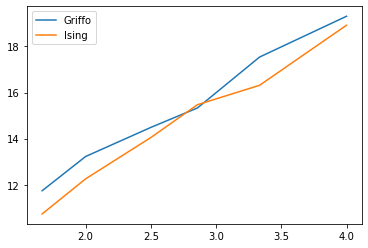

In [24]:
plt.plot(tempInverse, meantimes_grif,label='Griffo')
plt.plot(tempInverse, meantimes_ising, label='Ising')
ccrit = np.sqrt(8)/0.5
Ecrit = energy_grif(ccrit, 0.5)
#plt.plot(tempInverse, tempInverse * Ecrit + 7.9, label='Linear')
plt.legend()

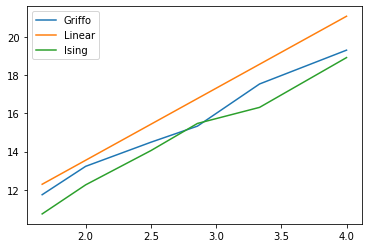

In [25]:
plt.plot(tempInverse, meantimes_grif,label='Griffo')
ccrit = np.sqrt(8)/0.5
Ecrit = energy_grif(ccrit, 0.5)
plt.plot(tempInverse, tempInverse * Ecrit + 6. , label='Linear')
plt.plot(tempInverse, meantimes_ising, label='Ising')
plt.legend()

In [26]:
ccrit


5.656854249492381

In [27]:
energy_ising(6,0.5), energy_grif(6,0.5)

(3.771236166328253, 3.75)

In [28]:
def saddle_ising (beta):
    return (1/beta)*np.log(np.exp(beta*energy_ising(6,0.5)) + np.exp(beta*(energy_ising(5,0.5) + energy_ising(1,0.5))) 
           +  np.exp(beta*(energy_ising(4,0.5) + energy_ising(2,0.5))) 
           +  np.exp(beta*(energy_ising(3,0.5) + energy_ising(3,0.5)))  )

In [29]:
def saddle_grif (beta):
    return (1/beta)*np.log(np.exp(beta*energy_grif(6,0.5)) + np.exp(beta*(energy_grif(5,0.5) + energy_grif(1,0.5))) 
           +  np.exp(beta*(energy_grif(4,0.5) + energy_grif(2,0.5))) 
           +  np.exp(beta*(energy_grif(3,0.5) + energy_grif(3,0.5)))  )
    

In [30]:
def saddle_ising (beta):
    return (1/beta)*np.log(np.exp(beta*energy_ising(6,0.5)) +
           +  np.exp(beta*(energy_ising(2,0.5)) )+  np.exp(beta*(energy_ising(1,0.5))))

In [31]:
def saddle_grif (beta):
    return (1/beta)*np.log(np.exp(beta*energy_grif(6,0.5)) +
           +  np.exp(beta*(energy_grif(2,0.5)) )+  np.exp(beta*(energy_grif(1,0.5))))

In [32]:
# def saddle_ising (beta):
#     return  np.log (np.exp(beta*5) + np.exp(beta*2)
#   )

In [33]:
# def saddle_grif (beta):
#     return np.log(np.exp(beta*5) + np.exp(beta*2)
#  )

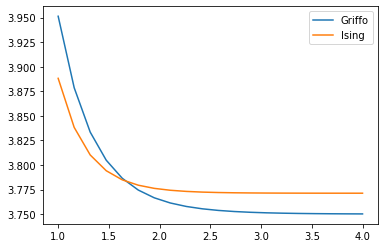

In [34]:
beta_range = np.linspace(1,4.0, num=20)
saddle_ising_res = saddle_ising(beta_range)
saddle_grif_res = saddle_grif(beta_range)
plt.plot(beta_range, 1.0*saddle_grif_res,label='Griffo')
plt.plot(beta_range, saddle_ising_res, label='Ising')
plt.legend()